## 3. Advanced features of Ray Serve

### Using fractions of a GPU

With Ray we can specify fractional compute resources for each deployment's replica. 

This is useful to help us fully utilize a GPU especially when running small models like our `MNISTClassifier` model.

Here is how to specify only 10% of a GPU's compute resources for our `MNISTClassifier` model.

In [9]:
mnist_app = OnlineMNISTClassifier.options(
    num_replicas=4, # we can scale to up to 10 replicas on a single GPU
    ray_actor_options={"num_gpus": 0.1}, 
).bind(local_path="/mnt/cluster_storage/model.pt")

Next we update the running application by running serve.run with the new options.

In [10]:
mnist_deployment_handle = serve.run(mnist_app, name='mnist_classifier', blocking=False)

2024-12-13 08:26:56,510	INFO handle.py:126 -- Created DeploymentHandle 't03z0nz6' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2024-12-13 08:26:56,511	INFO handle.py:126 -- Created DeploymentHandle 'nkuhydqb' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2024-12-13 08:27:05,544	INFO api.py:574 -- Deployed app 'mnist_classifier' successfully.


2024-12-13 08:27:01,026	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier'): {'3jw5er2a', '33le5oca', 'ldfdsx9y'}.
2024-12-13 08:27:04,963	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier'): {'3jw5er2a', 'yzcovfs1', '33le5oca', 'ldfdsx9y'}.
2024-12-13 08:33:39,268	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier'): set().
2024-12-13 08:35:20,218	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier'): {'rxr0eh2z'}.
2024-12-13 08:35:24,606	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier'): {'8g7ss5ya', 'rxr0eh2z', 'p50j70xb'}.
2024-12-13 08:35:27,930	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTClassifier', ap

We can test the new application by sending a sample request.

In [11]:
images = np.random.rand(2, 1, 28, 28).tolist()
json_request = json.dumps({"image": images})
response = requests.post("http://localhost:8000/", json=json_request)
response.json()["predicted_label"]

[1, 6]

### Customizing autoscaling

Ray Serve provides a simple way to autoscale the number of replicas in a deployment. It is primarily based on the target number of ongoing requests per replica.

i.e. here is how we can set the autoscaling config for our `OnlineMNISTClassifier` deployment.

In [12]:
mnist_app = OnlineMNISTClassifier.options(
    ray_actor_options={"num_gpus": 0.1}, 
    autoscaling_config={
        "target_ongoing_requests": 10,
    },
).bind(local_path="/mnt/cluster_storage/model.pt")

We can also control more granularly the autoscaling logic by setting:
- the upscale and downscale delays
- the intervals at which the replica sends metrics reports about the current number of ongoing requests
- the look-back period used to evaluate the current number of ongoing requests

Here is an example of how to set these options:

In [13]:
mnist_app = OnlineMNISTClassifier.options(
    ray_actor_options={"num_gpus": 0.1}, 
    autoscaling_config={
        "target_ongoing_requests": 10,
        "upscale_delay_s": 10,
        "downscale_delay_s": 10,
        "metrics_interval_s": 10,
        "look_back_period_s": 10, 
    },
).bind(local_path="/mnt/cluster_storage/model.pt")

We can additionally control the minimum and maximum number of replicas that can be scaled up and down. 

We can even specify to start scaling up from 0 replicas.

In [14]:
mnist_app = OnlineMNISTClassifier.options(
    ray_actor_options={"num_gpus": 0.1}, 
    autoscaling_config={
        "target_ongoing_requests": 10,
        "initial_replicas": 0, # scale up from 0 replicas
        "min_replicas": 0,
        "max_replicas": 10,
        # extreme upscale speeds
        "upscale_delay_s": 0,
        "metrics_interval_s": 0.1,
        "look_back_period_s": 0.1,
    },
).bind(local_path="/mnt/cluster_storage/model.pt")

Let's run the application with the new autoscaling config.

In [15]:
mnist_deployment_handle = serve.run(mnist_app, name='mnist_classifier', blocking=False)

2024-12-13 08:33:39,101	INFO handle.py:126 -- Created DeploymentHandle 'g1hdd0kd' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2024-12-13 08:33:39,102	INFO handle.py:126 -- Created DeploymentHandle 'r42tv4g9' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2024-12-13 08:33:42,117	INFO api.py:574 -- Deployed app 'mnist_classifier' successfully.


Looking at the Ray Serve dashboard, we can see we are currently at 0 replicas - i.e. no GPU resources are being used.

<img src='https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/autoscaling_at_0.png' width=700/>

We can send out a larger number of requests to the `OnlineMNISTClassifier` deployment to see the autoscaling in action.

In [16]:
batch = {"image": np.random.rand(10, 1, 28, 28)}
[
    mnist_deployment_handle.predict.remote(batch)
    for _ in range(100)
]

2024-12-13 08:35:16,122	INFO handle.py:126 -- Created DeploymentHandle 'o9qyndkq' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2024-12-13 08:35:16,123	INFO handle.py:126 -- Created DeploymentHandle 't4jr7eto' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2024-12-13 08:35:16,124	INFO handle.py:126 -- Created DeploymentHandle 'kmmsc84y' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2024-12-13 08:35:16,126	INFO handle.py:126 -- Created DeploymentHandle 'tsct5mrk' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2024-12-13 08:35:16,127	INFO handle.py:126 -- Created DeploymentHandle '43ppxrvj' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2024-12-13 08:35:16,130	INFO handle.py:126 -- Created DeploymentHandle 'i4i1kg29' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2024-12-13 08:35:16,132	INFO handle.py:126 -- Created DeploymentHandle '4keu50ib' for De

2024-12-13 08:35:21,559	WARNING pow_2_scheduler.py:501 -- Failed to get queue length from Replica(id='rxr0eh2z', deployment='OnlineMNISTClassifier', app='mnist_classifier') within 0.1s. If this happens repeatedly it's likely caused by high network latency in the cluster. You can configure the deadline using the `RAY_SERVE_QUEUE_LENGTH_RESPONSE_DEADLINE_S` environment variable.
2024-12-13 08:35:21,560	WARNING pow_2_scheduler.py:501 -- Failed to get queue length from Replica(id='rxr0eh2z', deployment='OnlineMNISTClassifier', app='mnist_classifier') within 0.1s. If this happens repeatedly it's likely caused by high network latency in the cluster. You can configure the deadline using the `RAY_SERVE_QUEUE_LENGTH_RESPONSE_DEADLINE_S` environment variable.
2024-12-13 08:35:21,890	WARNING pow_2_scheduler.py:501 -- Failed to get queue length from Replica(id='rxr0eh2z', deployment='OnlineMNISTClassifier', app='mnist_classifier') within 0.1s. If this happens repeatedly it's likely caused by high 

Looking at the Ray Serve dashboard, we can see that the number of replicas has scaled up to 10 as expected.

<img src='https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/autoscaling_at_10.png' width=700/>

Let's shutdown the service for now.

In [17]:
serve.shutdown()

### Composing Deployments

Ray Serve allows us to compose Deployments together to build more complex applications.

Lets compose our `OnlineMNISTClassifier` with an `OnlineMNISTPreprocessor` deployment that performs the necessary transformations on the input data.


In [18]:
from torchvision import transforms


@serve.deployment
class OnlineMNISTPreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        
    async def run(self, batch: dict[str, Any]) -> dict[str, Any]:
        images = batch["image"]
        images = [self.transform(np.array(image, dtype=np.uint8)).cpu().numpy() for image in images]
        return {"image": images}

preprocessor_app = OnlineMNISTPreprocessor.bind()

2024-12-13 08:38:36,797	WARNING api.py:346 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
2024-12-13 08:38:36,797	WARNING api.py:397 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.


In [19]:
preprocessor_handle = serve.run(preprocessor_app, name='mnist_preprocessor', blocking=False, route_prefix="/preprocess")

2024-12-13 08:38:44,236	INFO handle.py:126 -- Created DeploymentHandle '8px5rnva' for Deployment(name='OnlineMNISTPreprocessor', app='mnist_preprocessor').
2024-12-13 08:38:44,237	INFO handle.py:126 -- Created DeploymentHandle 'l4gmboko' for Deployment(name='OnlineMNISTPreprocessor', app='mnist_preprocessor').
2024-12-13 08:38:49,254	INFO handle.py:126 -- Created DeploymentHandle 'gf1a4vjq' for Deployment(name='OnlineMNISTPreprocessor', app='mnist_preprocessor').
2024-12-13 08:38:49,255	INFO api.py:574 -- Deployed app 'mnist_preprocessor' successfully.


Let's load an image and pass it to the `OnlineMNISTPreprocessor`

In [20]:
import ray

ds = ray.data.read_images("s3://anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/", include_paths=True)
image_batch = ds.take_batch(10)

2024-12-13 08:39:23,784	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-12-13_08-07-01_151483_2430/logs/ray-data
2024-12-13 08:39:23,785	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ExpandPaths] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=10]


- ExpandPaths 1: 0 bundle [00:00, ? bundle/s]

- ReadFiles 2: 0 bundle [00:00, ? bundle/s]

- limit=10 3: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

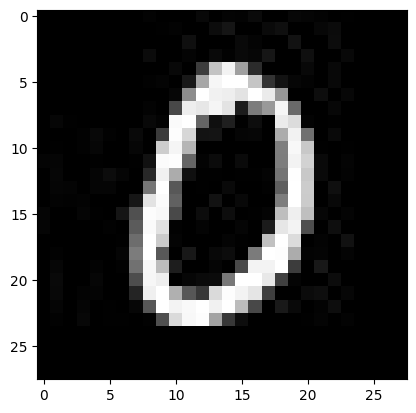

In [21]:
# plot the first image using matplotlib
from matplotlib import pyplot as plt


plt.imshow(image_batch["image"][0], cmap="gray")
plt.show()

In [22]:
normalized_batch = await preprocessor_handle.run.remote(image_batch)

for image in normalized_batch["image"]:
    assert image.shape == (1, 28, 28) # channel, height, width
    assert image.min() >= -1 and image.max() <= 1 # normalized to [-1, 1]

2024-12-13 08:39:56,494	INFO handle.py:126 -- Created DeploymentHandle 'oy7ram11' for Deployment(name='OnlineMNISTPreprocessor', app='mnist_preprocessor').


We will proceed to shutdown the preprocessor application to prove it will be automatically recreated later.


In [23]:
serve.shutdown()

Let's now build an application that composes the `OnlineMNISTPreprocessor` and `OnlineMNISTClassifier`

In [24]:
@serve.deployment
class ImageServiceIngress:
    def __init__(self, preprocessor: OnlineMNISTPreprocessor, model: OnlineMNISTClassifier):
        self.preprocessor = preprocessor
        self.model = model

    async def __call__(self, request: Request):
        batch = json.loads(await request.json())
        response = await self.preprocessor.run.remote(batch)
        return await self.model.predict.remote(response)

2024-12-13 08:42:47,216	WARNING api.py:346 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
2024-12-13 08:42:47,217	WARNING api.py:397 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.


In [25]:
image_classifier_ingress = ImageServiceIngress.bind(
    preprocessor=OnlineMNISTPreprocessor.bind(),
    model=OnlineMNISTClassifier.options(
        num_replicas=1,
        ray_actor_options={"num_gpus": 0.1},
    ).bind(local_path="/mnt/cluster_storage/model.pt"),
)

handle = serve.run(image_classifier_ingress, name='image_classifier', blocking=False)

2024-12-13 08:44:19,957	INFO handle.py:126 -- Created DeploymentHandle 'fsqpub6j' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2024-12-13 08:44:19,963	INFO handle.py:126 -- Created DeploymentHandle 'o631o8sp' for Deployment(name='OnlineMNISTClassifier', app='image_classifier').
2024-12-13 08:44:19,964	INFO handle.py:126 -- Created DeploymentHandle 's082atuf' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2024-12-13 08:44:19,964	INFO handle.py:126 -- Created DeploymentHandle 'l8s57gz6' for Deployment(name='OnlineMNISTClassifier', app='image_classifier').
2024-12-13 08:44:19,971	INFO handle.py:126 -- Created DeploymentHandle '3mpn24fn' for Deployment(name='ImageServiceIngress', app='image_classifier').
2024-12-13 08:44:19,972	INFO handle.py:126 -- Created DeploymentHandle 'lwk6vdl4' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2024-12-13 08:44:19,972	INFO handle.py:126 -- Created DeploymentHandle 'hsxt2a9i' fo

Let's test the application by sending a sample HTTP request to our ingress endpoint.


In [26]:
json_request = json.dumps({"image": image_batch["image"].tolist()}) 
response = requests.post("http://localhost:8000/", json=json_request)
response.json()["predicted_label"]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Integrating with FastAPI

Ray Serve can be integrated with FastAPI to provide:
- HTTP routing
- Pydantic model validation
- OpenAPI documentation

To integrate a Deployment with FastAPI, we can use the `@serve.ingress` decorator to designate a FastAPI app as the entrypoint for HTTP requests to our Serve application.

In [27]:
from fastapi import FastAPI


app = FastAPI()

@serve.deployment
@serve.ingress(app)
class ImageServiceIngress:
    def __init__(self, preprocessor: OnlineMNISTPreprocessor, model: OnlineMNISTClassifier):
        self.preprocessor = preprocessor
        self.model = model
    
    @app.post("/predict")
    async def predict(self, request: Request):
        batch = json.loads(await request.json())
        response = await self.preprocessor.run.remote(batch)
        out = await self.model.predict.remote(response)
        return {"predicted_label": out["predicted_label"].tolist()}

2024-12-13 08:48:29,697	WARNING api.py:346 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
2024-12-13 08:48:29,698	WARNING api.py:397 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.


We now can build the application and run it.

In [28]:
image_classifier_ingress = ImageServiceIngress.bind(
    preprocessor=OnlineMNISTPreprocessor.bind(),
    model=OnlineMNISTClassifier.options(
        num_replicas=1,
        ray_actor_options={"num_gpus": 0.1},
    ).bind(local_path="/mnt/cluster_storage/model.pt"),
)

handle = serve.run(image_classifier_ingress, name='image_classifier', blocking=False)

2024-12-13 08:49:02,196	INFO handle.py:126 -- Created DeploymentHandle 'zs9xlv6l' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2024-12-13 08:49:02,201	INFO handle.py:126 -- Created DeploymentHandle 'e6czhw0i' for Deployment(name='OnlineMNISTClassifier', app='image_classifier').
2024-12-13 08:49:02,201	INFO handle.py:126 -- Created DeploymentHandle 's26zdw7w' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2024-12-13 08:49:02,202	INFO handle.py:126 -- Created DeploymentHandle '73tfa712' for Deployment(name='OnlineMNISTClassifier', app='image_classifier').
2024-12-13 08:49:02,212	INFO handle.py:126 -- Created DeploymentHandle '8ywfb0i5' for Deployment(name='ImageServiceIngress', app='image_classifier').
2024-12-13 08:49:02,212	INFO handle.py:126 -- Created DeploymentHandle '2fvhvuyy' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2024-12-13 08:49:02,213	INFO handle.py:126 -- Created DeploymentHandle '500czr1l' fo

After running the application, we can get test it as an HTTP endpoint programmatically.

In [29]:
json_request = json.dumps({"image": image_batch["image"].tolist()}) 
response = requests.post("http://localhost:8000/predict", json=json_request)
response.json()["predicted_label"]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We can also visit the auto-generated FastAPI docs at http://localhost:8000/docs to get an interactive UI to test our endpoint.